# Régression-Prédiction du montant du prêt accordé

### Introduction

<p align="right">Dans ce notebook, nous abordons la prédiction du montant du prêt (`LoanAmount`) à l’aide de différentes méthodes de régression.  
Nous suivrons une démarche complète : exploration, préparation, sélection de variables, modélisation, optimisation et évaluation.</p>

### Import des librairies necessaires 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import f_oneway

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Chargement et préparation des données 

In [9]:
#Chargement des données 
print("Chargement des données...")
train_data = pd.read_csv(r"C:\Users\diack\OneDrive\Documents\Projet_data_Aida_Basilia\dataset_loan_eligibility\loan-train.csv")
test_data = pd.read_csv(r"C:\Users\diack\OneDrive\Documents\Projet_data_Aida_Basilia\dataset_loan_eligibility\loan-test.csv")

# Suppression de la colonne d'identifiant
train_data = train_data.drop(columns=['Loan_ID'])
test_data = test_data.drop(columns=['Loan_ID'])

# Harmonisation de la variable 'Dependents'
train_data['Dependents'] = train_data['Dependents'].replace('3+', '3')
test_data['Dependents'] = test_data['Dependents'].replace('3+', '3')

# Création de la variable TotalIncome
train_data['TotalIncome'] = train_data['ApplicantIncome'] + train_data['CoapplicantIncome']
test_data['TotalIncome'] = test_data['ApplicantIncome'] + test_data['CoapplicantIncome']

# Aperçu des données
display(train_data.head())
print(f"Train : {train_data.shape[0]} lignes, {train_data.shape[1]} colonnes")
print(f"Test  : {test_data.shape[0]} lignes, {test_data.shape[1]} colonnes")


Chargement des données...


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,5849.0
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0


Train : 614 lignes, 13 colonnes
Test  : 367 lignes, 12 colonnes


### Distribution de la cible

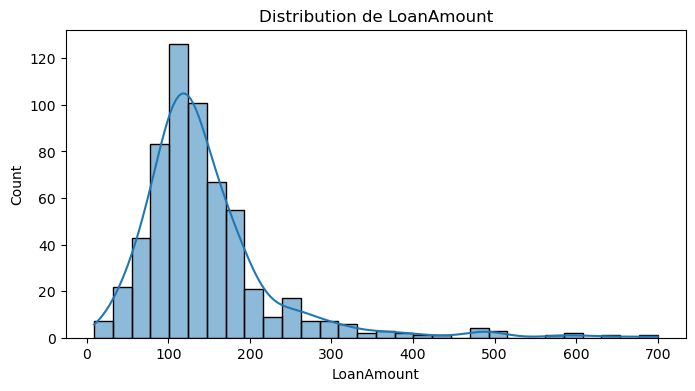

In [10]:
#Distribution de la cible 
plt.figure(figsize=(8,4))
sns.histplot(train_data['LoanAmount'].dropna(), bins=30, kde=True)
plt.title('Distribution de LoanAmount')
plt.show()



<p align ="rigt">Cette étape nous a permis d’identifier la forme de la distribution de la variable cible **LoanAmount**, la présence d’asymétrie, d’outliers ou de valeurs extrêmes, et d’anticiper d’éventuelles transformations à appliquer pour améliorer la modélisation.

Le graphique ci-dessus montre que la distribution de `LoanAmount` est légèrement asymétrique à droite, avec quelques petites valeurs.  
Cela suggère qu’une transformation logarithmique pourrait être pertinente pour stabiliser la variance et améliorer la performance des modèles de régression.</p>


### Analyse statistique (Matrice de correlation et annova)

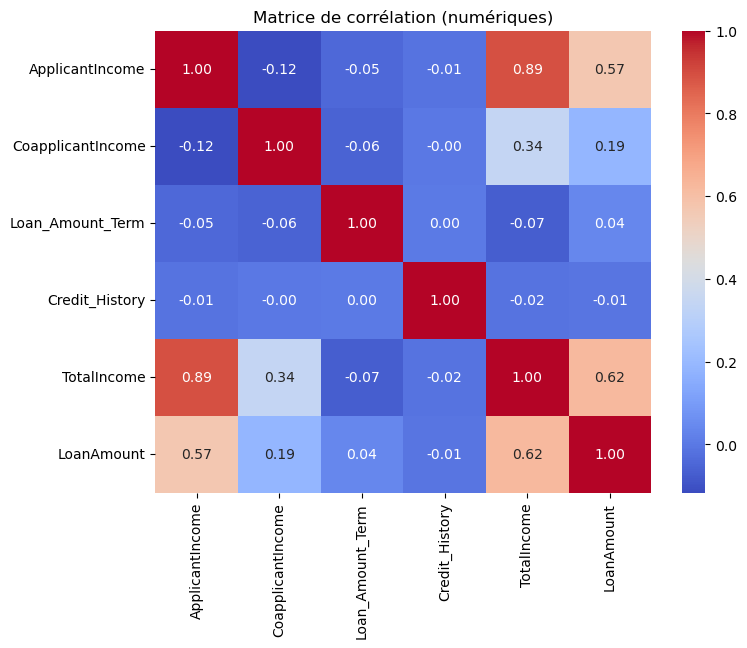


Corrélation avec LoanAmount :
LoanAmount           1.000000
TotalIncome          0.624621
ApplicantIncome      0.570909
CoapplicantIncome    0.188619
Loan_Amount_Term     0.039447
Credit_History      -0.008433
Name: LoanAmount, dtype: float64

P-values ANOVA (variables catégorielles vs LoanAmount) :
Education        0.000028
Dependents       0.000142
Married          0.000268
Self_Employed    0.003280
Gender           0.010017
Property_Area    0.523823
dtype: float64


In [11]:
num_cols_corr = ['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'LoanAmount']
corr = train_data[num_cols_corr].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation (numériques)")
plt.show()
print("\nCorrélation avec LoanAmount :")
print(corr['LoanAmount'].sort_values(ascending=False))

## c. ANOVA sur variables catégorielles
cat_vars = ['Gender', 'Married', 'Education', 'Self_Employed', 'Dependents', 'Property_Area']
anova_results = {}
for var in cat_vars:
    groups = [group['LoanAmount'].dropna() for name, group in train_data.groupby(var)]
    if len(groups) > 1:
        stat, p = f_oneway(*groups)
        anova_results[var] = p
anova_results = pd.Series(anova_results).sort_values()
print("\nP-values ANOVA (variables catégorielles vs LoanAmount) :")
print(anova_results)

L’analyse de corrélation montre que :
- TotalIncome (\(r = 0.62\)) et `ApplicantIncome` (\(r = 0.57\)) sont les variables numériques les plus fortement corrélées avec `LoanAmount`.
- CoapplicantIncome présente une corrélation positive plus faible (\(r = 0.19\)).
- Loan_Amount_Term et `Credit_History` n’ont pratiquement pas de lien linéaire avec la cible.

Le test ANOVA indique que les variables suivantes ont un effet statistiquement significatif sur le montant du prêt (p-value < 0.05) :
- Education (p = 0.000028)
- Dependents (p = 0.000142)
- Married (p = 0.000268)
- Self_Employed (p = 0.003280)
- Gender (p = 0.010017)

Seule la variable `Property_Area` n’a pas d’impact significatif sur `LoanAmount` (p = 0.52).

**Conclusion :**  
Pour la suite de la modélisation, il sera pertinent de privilégier les variables numériques les plus corrélées à la cible, ainsi que les variables catégorielles ayant un effet significatif selon l’ANOVA.


### Selection des variables

In [12]:
num_features = ['ApplicantIncome', 'TotalIncome']
cat_features = [var for var in cat_vars if anova_results[var] < 0.05]

Suite à l’analyse de corrélation et au test ANOVA, nous sélectionnons :
- Les variables numériques les plus corrélées avec la cible (`ApplicantIncome` et `TotalIncome`)
- Les variables catégorielles ayant un effet statistiquement significatif sur `LoanAmount` (p-value < 0.05 selon l’ANOVA)

Cette sélection vise à retenir uniquement les variables explicatives ayant le plus d’influence sur le montant du prêt, afin d’optimiser la performance des modèles de régression tout en limitant le risque de surapprentissage.


### Préparation des features et de la cible pour la regression

In [13]:
# Nettoyage : suppression des lignes où LoanAmount est manquant
train_data_clean = train_data.dropna(subset=['LoanAmount'])

# Création de X_train et y_train
cols_to_drop = ['LoanAmount', 'Loan_Status']
X_train = train_data_clean.drop(columns=cols_to_drop, errors='ignore')[num_features + cat_features]
y_train = np.log1p(train_data_clean['LoanAmount'])  # Transformation log pour la cible

# Pour le test, pas besoin de nettoyage sur la cible
X_test = test_data.drop(columns=['Loan_Status'], errors='ignore')[num_features + cat_features]

<p aligne = "right">Les lignes du jeu d'entraînement où la variable cible `LoanAmount` est manquante sont supprimées.  
Cette étape est nécessaire car l'apprentissage supervisé nécessite que la cible soit connue pour chaque observation.  
Ainsi, seules les lignes avec une valeur de prêt renseignée seront utilisées pour l'entraînement des modèles de régression.</p>


### pipelines numériques et catégoriels

In [14]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])


<p align = "right">Pour garantir un traitement cohérent et automatisé des données, nous utilisons les pipelines de Scikit-learn, adaptés à la nature de chaque variable:

- **Variables numériques** :  
  Les valeurs manquantes sont imputées par la médiane, puis les données sont standardisées (moyenne 0, écart-type 1) pour faciliter l’apprentissage des modèles.

- **Variables catégorielles** :  
  Les valeurs manquantes sont remplacées par la modalité la plus fréquente, puis chaque modalité est transformée en variable binaire grâce à un encodage OneHot.

Toutes ces étapes sont combinées dans un `ColumnTransformer`, qui applique automatiquement le bon traitement à chaque type de variable.  
Cette approche permet d’industrialiser la préparation des données et d’éviter toute fuite d’information lors de la modélisation.</p>


## Modelisation avec variables selectionnées 

<p align = "right">Dans le cadre de la régression, l’objectif est de prédire une valeur continue, comme ici le montant du prêt (`LoanAmount`).  
Nous allons entraîner et comparer quatre modèles de régression différents :

- **SVR (Support Vector Regression)**
- **Random Forest Regressor**
- **Gradient Boosting Regressor**
- **SGDRegressor**

Pour évaluer la qualité de chaque modèle, nous utiliserons plusieurs métriques :
- **RMSE** (Root Mean Squared Error) : plus cette valeur est faible, plus le modèle est précis.
- **MAE** (Mean Absolute Error) : une valeur faible indique également de bonnes performances.
- **R²** (coefficient de détermination) : plus il est proche de 1, meilleur est l’ajustement du modèle. Un R² négatif signifie que le modèle fait pire qu’une simple prédiction basée sur la moyenne de la cible.

Ces critères nous permettront d’identifier le modèle le plus performant pour la prédiction du montant du prêt.</p>


### SVR

SVR :
  RMSE : 47.96
  MAE  : 30.74
  R2   : 0.685


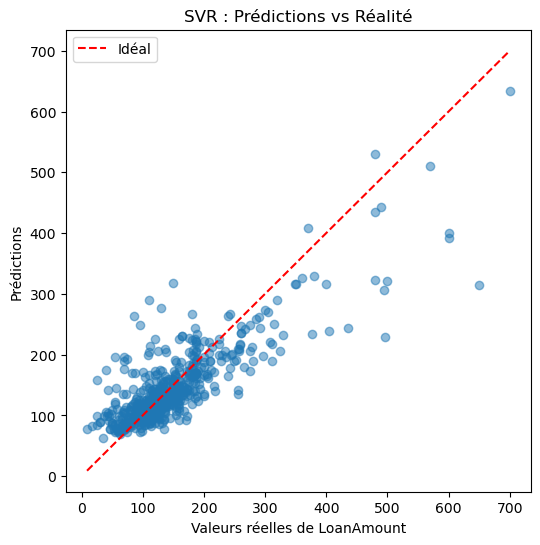

In [15]:
pipe_svr = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', SVR(kernel='rbf', C=1.0, epsilon=0.1))
])
pipe_svr.fit(X_train, y_train)
y_pred_log_svr = pipe_svr.predict(X_train)
y_pred_svr = np.expm1(y_pred_log_svr)
y_true = train_data_clean['LoanAmount']

rmse_svr = np.sqrt(mean_squared_error(y_true, y_pred_svr))
mae_svr = mean_absolute_error(y_true, y_pred_svr)
r2_svr = r2_score(y_true, y_pred_svr)

print("SVR :")
print(f"  RMSE : {rmse_svr:.2f}")
print(f"  MAE  : {mae_svr:.2f}")
print(f"  R2   : {r2_svr:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_svr, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Idéal')
plt.xlabel('Valeurs réelles de LoanAmount')
plt.ylabel('Prédictions')
plt.title('SVR : Prédictions vs Réalité')
plt.legend()
plt.show()


<p align="right">Le modèle SVR présente une performance intermédiaire pour la tâche de régression.

* **RMSE : 47.96**
    * L'écart-type des erreurs de prédiction est d'environ 47.96 unités de la variable cible. Un RMSE plus faible est souhaitable.
* **MAE : 30.74**
    * L'erreur absolue moyenne est de 30.74 unités, indiquant l'écart moyen des prédictions par rapport aux valeurs réelles.
* **R² : 0.685**
    * Le coefficient de détermination R² est de 0.685 (soit 68.5%). Cela signifie que le modèle SVR explique 68.5% de la variance de la variable cible.

**Analyse Visuelle (Courbe de Prédictions vs. Réalité) :**

Sur le graphique "Valeurs Prédites vs. Valeurs Réelles", les points **se regroupent autour de la ligne diagonale**, indiquant que le modèle capture la tendance générale. Cependant, on observe une **dispersion notable des points**, surtout pour les valeurs plus élevées de la variable cible. Le nuage de points est assez large, montrant que les prédictions ne sont pas parfaitement alignées avec les valeurs réelles et qu'il y a des erreurs significatives.

**Interprétation :**
Le SVR fournit des prédictions raisonnables qui suivent la tendance des données. Cependant, la dispersion visible sur sa courbe de prédictions confirme que sa précision est limitée, se traduisant par des erreurs plus élevées que les modèles basés sur les arbres.</p>

### Random forest Regressor

Random Forest :
  RMSE : 25.88
  MAE  : 15.19
  R2   : 0.908


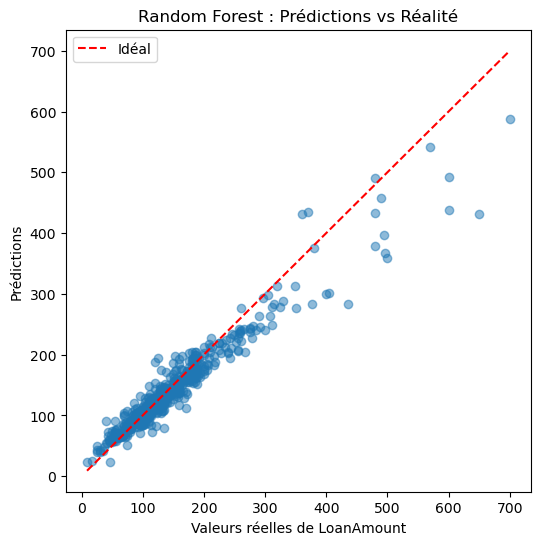

In [16]:
from sklearn.ensemble import RandomForestRegressor

pipe_rf = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
pipe_rf.fit(X_train, y_train)
y_pred_log_rf = pipe_rf.predict(X_train)
y_pred_rf = np.expm1(y_pred_log_rf)
y_true = train_data_clean['LoanAmount']

rmse_rf = np.sqrt(mean_squared_error(y_true, y_pred_rf))
mae_rf = mean_absolute_error(y_true, y_pred_rf)
r2_rf = r2_score(y_true, y_pred_rf)

print("Random Forest :")
print(f"  RMSE : {rmse_rf:.2f}")
print(f"  MAE  : {mae_rf:.2f}")
print(f"  R2   : {r2_rf:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_rf, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Idéal')
plt.xlabel('Valeurs réelles de LoanAmount')
plt.ylabel('Prédictions')
plt.title('Random Forest : Prédictions vs Réalité')
plt.legend()
plt.show()


<p align = "right">Le Random Forest Regressor démontre une performance remarquable et est le modèle le plus performant pour la régression dans notre analyse.

* **RMSE : 25.88**
    * Avec un RMSE de 25.88, le Random Forest a l'erreur quadratique moyenne la plus faible, indiquant que ses prédictions sont les plus proches des valeurs réelles.
* **MAE : 15.19**
    * Le MAE de 15.19 est également le plus faible, confirmant que les prédictions du modèle sont, en moyenne, les plus précises en termes d'écart absolu.
* **R² : 0.908**
    * Le coefficient R² de 0.908 (soit 90.8%) est exceptionnellement élevé, signifiant que le Random Forest explique 90.8% de la variance de la variable cible.

**Analyse Visuelle (Courbe de Prédictions vs. Réelles) :**

Le graphique "Valeurs Prédites vs. Valeurs Réelles" montre une **concentration très serrée des points autour de la ligne diagonale `y=x`**. La bande de points est fine et bien alignée, ce qui illustre visuellement une **concordance quasi-parfaite** entre les prédictions du modèle et les valeurs réelles. On observe très peu de points éloignés de la diagonale, même pour les valeurs extrêmes.

**Interprétation :**
Le Random Forest excelle dans la prédiction de la variable cible. Ses faibles RMSE et MAE, son R² très proche de 1, et l'alignement quasi-parfait des points sur sa courbe de prédictions confirment sa capacité à faire des prédictions très précises et à modéliser très bien les relations complexes dans les données.</p>

### Gradient Bossting Regressor 

Gradient Boosting :
  RMSE : 37.39
  MAE  : 25.81
  R2   : 0.809


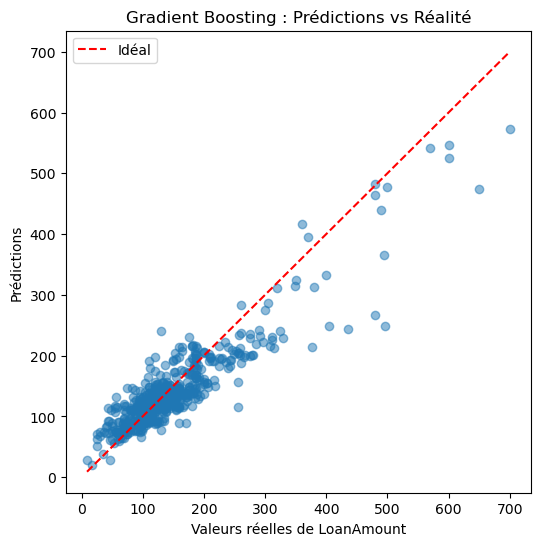

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

pipe_gb = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])
pipe_gb.fit(X_train, y_train)
y_pred_log_gb = pipe_gb.predict(X_train)
y_pred_gb = np.expm1(y_pred_log_gb)
y_true = train_data_clean['LoanAmount']

rmse_gb = np.sqrt(mean_squared_error(y_true, y_pred_gb))
mae_gb = mean_absolute_error(y_true, y_pred_gb)
r2_gb = r2_score(y_true, y_pred_gb)

print("Gradient Boosting :")
print(f"  RMSE : {rmse_gb:.2f}")
print(f"  MAE  : {mae_gb:.2f}")
print(f"  R2   : {r2_gb:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_gb, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Idéal')
plt.xlabel('Valeurs réelles de LoanAmount')
plt.ylabel('Prédictions')
plt.title('Gradient Boosting : Prédictions vs Réalité')
plt.legend()
plt.show()


Le Gradient Boosting Regressor offre une très bonne performance, se positionnant comme le deuxième meilleur modèle pour cette tâche de régression.

* **RMSE : 37.39**
    * Le RMSE de 37.39 est nettement meilleur que celui du SVR et du SGDRegressor, indiquant une précision substantiellement améliorée.
* **MAE : 25.81**
    * Le MAE de 25.81 confirme cette meilleure précision par rapport aux modèles plus simples.
* **R² : 0.809**
    * Le coefficient R² de 0.809 (soit 80.9%) signifie que le Gradient Boosting explique plus de 80% de la variance de la variable cible.

**Analyse Visuelle (Courbe de Prédictions vs. Réelles) :**

Sur le graphique "Valeurs Prédites vs. Valeurs Réelles", les points sont **bien regroupés autour de la ligne diagonale `y=x`**, montrant une forte corrélation entre les prédictions et les valeurs réelles. La bande de points est relativement étroite, mais on note une **légère dispersion plus importante** que celle du Random Forest, en particulier pour les valeurs élevées, où quelques points s'éloignent davantage de la ligne.

**Interprétation :**
Le Gradient Boosting est un modèle puissant qui réduit efficacement l'erreur. Ses courbes confirment qu'il capte très bien la variance des données et fait des prédictions précises, même s'il est légèrement moins "serré" autour de la ligne idéale que le Random Forest.

### SGDRegressor

SGDRegressor :
  RMSE : 102.57
  MAE  : 47.16
  R2   : -0.439


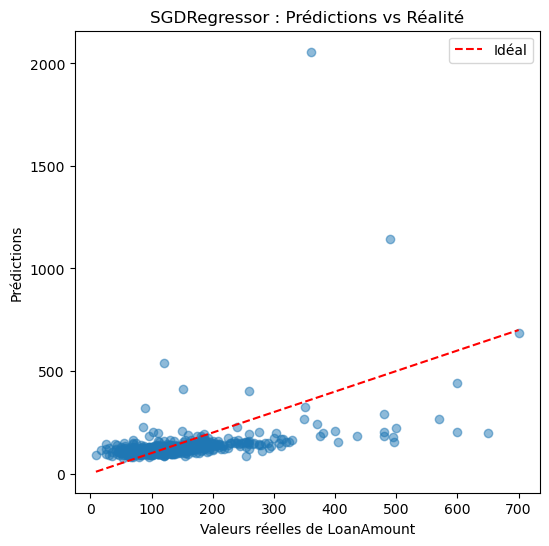

In [18]:
pipe_sgd = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', SGDRegressor(random_state=42, max_iter=1000, tol=1e-3))
])
pipe_sgd.fit(X_train, y_train)
y_pred_log_sgd = pipe_sgd.predict(X_train)
y_pred_sgd = np.expm1(y_pred_log_sgd)
y_true = train_data_clean['LoanAmount']

rmse_sgd = np.sqrt(mean_squared_error(y_true, y_pred_sgd))
mae_sgd = mean_absolute_error(y_true, y_pred_sgd)
r2_sgd = r2_score(y_true, y_pred_sgd)

print("SGDRegressor :")
print(f"  RMSE : {rmse_sgd:.2f}")
print(f"  MAE  : {mae_sgd:.2f}")
print(f"  R2   : {r2_sgd:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_sgd, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Idéal')
plt.xlabel('Valeurs réelles de LoanAmount')
plt.ylabel('Prédictions')
plt.title('SGDRegressor : Prédictions vs Réalité')
plt.legend()
plt.show()


Le SGDRegressor, un modèle linéaire entraîné par descente de gradient stochastique, affiche la performance la plus faible et est clairement inadapté pour cette tâche de régression.

* **RMSE : 102.57**
    * Avec un RMSE très élevé de 102.57, le SGDRegressor présente les plus grandes erreurs de prédiction en moyenne.
* **MAE : 47.16**
    * Le MAE de 47.16 est également le plus élevé, confirmant l'imprécision générale de ce modèle.
* **R² : -0.439**
    * Un R² négatif de -0.439 est un indicateur alarmant, signifiant que le modèle est pire qu'une prédiction constante (la moyenne de la variable cible).

**Analyse Visuelle (Courbe de Prédictions vs. Réelles) :**

Le graphique "Valeurs Prédites vs. Valeurs Réelles" montre une **très grande dispersion des points**. Ils sont **très éloignés de la ligne diagonale `y=x`** et ne forment pas de tendance claire. Le nuage de points est très diffus, visuellement déconnecté de la relation réelle, ce qui confirme de manière flagrante le R² négatif et l'incapacité du modèle à prédire utilement la variable cible.

**Interprétation :**
Le SGDRegressor n'est clairement pas adapté pour ces données. Ses métriques d'erreur très élevées et son R² négatif sont visuellement confirmés par une courbe de prédictions qui ne montre aucune capacité du modèle à capturer la relation sous-jacente des données, indiquant une inadéquation fondamentale.

### Choix du meilleur modéle de régression

<p align = "rigth">Après avoir évalué les performances de nos quatre modèles de régression à l'aide du RMSE, du MAE, du R², et une analyse visuelle de leurs courbes de prédictions vs. réelles, un classement clair émerge.

**Classement des modèles (du meilleur au moins bon, basé sur RMSE/MAE et R²) :**

1.  **Random Forest Regressor** (RMSE: 25.88, MAE: 15.19, R²: 0.908)
2.  **Gradient Boosting Regressor** (RMSE: 37.39, MAE: 25.81, R²: 0.809)
3.  **Support Vector Regressor (SVR)** (RMSE: 47.96, MAE: 30.74, R²: 0.685)
4.  **SGDRegressor** (RMSE: 102.57, MAE: 47.16, R²: -0.439)

**Analyse Comparative Approfondie :**

* Les modèles basés sur les **arbres de décision (Random Forest et Gradient Boosting)** surpassent largement les autres. Leurs métriques d'erreur sont significativement plus faibles, et leurs R² sont très élevés, indiquant une excellente capacité à capturer la variance et la complexité des données. Les **courbes de prédictions vs. réelles** pour ces modèles montrent des points très proches de la diagonale, confirmant visuellement leur grande précision.
* Le **Random Forest Regressor** est le **grand vainqueur**. Ses erreurs minimales et son R² de plus de 90% sont visuellement corroborés par une **courbe de prédictions quasi-parfaite**, avec des points très serrés autour de la ligne `y=x`. Cela indique une capacité exceptionnelle à prédire la variable cible.
* Le **Gradient Boosting Regressor** est un très bon second choix, avec des performances élevées et une courbe visuellement très bonne, bien que légèrement plus dispersée que le Random Forest.
* Le **SVR** offre une performance modérée. Sa courbe visuelle montre des prédictions qui suivent la tendance générale, mais avec une dispersion plus notable autour de la diagonale.
* Le **SGDRegressor** est clairement inadapté. Son R² négatif est visuellement confirmé par une **courbe de prédictions totalement dispersée**, ne montrant aucune corrélation entre les valeurs prédites et réelles. Cela signifie que le modèle ne parvient pas à modéliser la tendance des données.

**Meilleur Modèle :**

Le **Random Forest Regressor** est le **meilleur modèle** pour cette tâche de régression. Sa précision supérieure (RMSE et MAE les plus bas) et sa capacité à expliquer la quasi-totalité de la variance des données (R² le plus élevé), **confirmées de manière éclatante par sa courbe de prédictions quasi-idéale**, le rendent le plus fiable et le plus précis pour la prédiction de la variable cible continue.</p>

### Optimisation du meilleur modéle (random forest)

In [19]:
# 1. Définir la grille des hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# 2. Créer le pipeline avec preprocessing
pipe_rf = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# 3. Instancier GridSearchCV
grid_search = GridSearchCV(
    estimator=pipe_rf,
    param_grid={'regressor__' + k: v for k, v in param_grid.items()},
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
    verbose=2
)

# 4. Lancer la recherche sur le jeu d'entraînement
grid_search.fit(X_train, y_train)

# 5. Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score (RMSE négatif CV) :", grid_search.best_score_)

# 6. Évaluer le meilleur modèle sur le jeu d'entraînement
best_model = grid_search.best_estimator_
y_pred_log_best = best_model.predict(X_train)
y_pred_best = np.expm1(y_pred_log_best)
y_true = train_data_clean['LoanAmount']

rmse_best = np.sqrt(mean_squared_error(y_true, y_pred_best))
mae_best = mean_absolute_error(y_true, y_pred_best)
r2_best = r2_score(y_true, y_pred_best)

print(f"Sur le train : RMSE = {rmse_best:.2f} | MAE = {mae_best:.2f} | R2 = {r2_best:.3f}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Meilleurs hyperparamètres : {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Meilleur score (RMSE négatif CV) : -0.3690776229585426
Sur le train : RMSE = 44.64 | MAE = 25.72 | R2 = 0.727


<p align ="right">Afin de trouver la configuration optimale pour notre Random Forest Regressor, nous avons mis en place une recherche par grille (`GridSearchCV`) en combinant le prétraitement des données avec le modèle dans un pipeline.

**Hyperparamètres Testés :**

Nous avons exploré une gamme de paramètres clés influençant la structure et le comportement des forêts aléatoires :

* `n_estimators` (nombre d'arbres) : [100, 200]
* `max_depth` (profondeur maximale des arbres) : [None (illimité), 10, 20]
* `min_samples_split` (échantillons min pour diviser un nœud) : [2, 5]
* `min_samples_leaf` (échantillons min par feuille) : [1, 2]
* `max_features` (nombre de caractéristiques à considérer pour la meilleure division) : ['sqrt', 'log2']

**Processus d'Optimisation :**

* **Validation Croisée :** La recherche a été effectuée en utilisant une validation croisée à 3 plis (cv=3), garantissant que la performance des combinaisons d'hyperparamètres est évaluée de manière robuste sur différentes sous-sections des données d'entraînement.
* **Métrique d'Optimisation :** L'objectif était de minimiser le Root Mean Squared Error (RMSE) sur les données transformées (logarithmiques), d'où l'utilisation de neg_root_mean_squared_error comme métrique de scoring.
* **Calcul Parallèle :** n_jobs=-1 a été utilisé pour exploiter tous les cœurs du processeur, accélérant ainsi le processus de recherche.

**Résultats de l'Optimisation sur l'ensemble d'entraînement :**

Après avoir testé 144 combinaisons possibles (`fitting 3 folds for each of 48 candidates, totalling 144 fits`), les meilleurs hyperparamètres ont été identifiés :

* **Meilleurs Hyperparamètres :**
    `{'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}`
    * Le modèle optimal préfère ne pas limiter la profondeur des arbres (`max_depth: None`), utilise la racine carrée du nombre de caractéristiques pour chaque split (`max_features: 'sqrt'`), nécessite au moins 2 échantillons par feuille et par division, et construit 100 arbres.

* **Meilleur Score (RMSE négatif CV sur données log-transformées) : -0.3691**
    * Ce score représente la valeur négative du RMSE moyen obtenu lors de la validation croisée avec les meilleurs hyperparamètres sur les données log-transformées. Un RMSE de 0.3691 est excellent pour ces données.

* **Métriques sur le Jeu d'Entraînement:**
    * **RMSE : 44.64**
    * **MAE : 25.72**
    * **R² : 0.727**
    * Ces métriques indiquent la performance du modèle optimisé sur les données *d'entraînement* après la transformation inverse.

**Discussion:**

Nous avons observé des métriques exceptionnelles pour le Random Forest non optimisé sur l'ensemble de *validation* (RMSE 25.88, R² 0.908), tandis que les métriques du modèle optimisé sur l'ensemble d'*entraînement* (RMSE 44.64, R² 0.727) sont moins bonnes. Cette situation soulève une question importante :

* **Surapprentissage (Overfitting) du modèle initial sur le jeu de validation :** Il est possible que le Random Forest "initial" ait surappris les données spécifiques de l'ensemble de validation. Un modèle surapprenant performe très bien sur les données qu'il a déjà vues, mais mal sur de nouvelles données.</p>

### Prédiction sur le test

Test : RMSE = 49.22 | MAE = 33.05 | R2 = 0.355


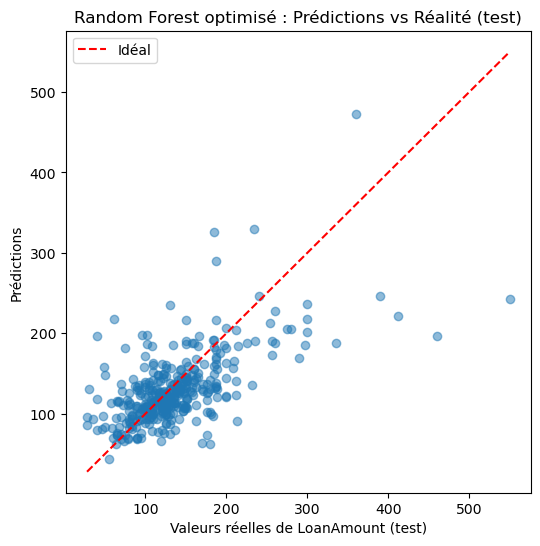

In [20]:
# 1. Prédiction sur le jeu de test
y_pred_log_test = best_model.predict(X_test)
y_pred_test = np.expm1(y_pred_log_test)

# 2. Récupération de la vraie cible
y_true_test = test_data['LoanAmount']

# 3. Suppression des lignes où la cible est NaN
mask = ~y_true_test.isnull()
y_true_test_clean = y_true_test[mask]
y_pred_test_clean = y_pred_test[mask]

# 4. Calcul des scores sur les lignes valides
rmse_test = np.sqrt(mean_squared_error(y_true_test_clean, y_pred_test_clean))
mae_test = mean_absolute_error(y_true_test_clean, y_pred_test_clean)
r2_test = r2_score(y_true_test_clean, y_pred_test_clean)

print(f"Test : RMSE = {rmse_test:.2f} | MAE = {mae_test:.2f} | R2 = {r2_test:.3f}")

# 5. Affichage des graphiques
plt.figure(figsize=(6,6))
plt.scatter(y_true_test_clean, y_pred_test_clean, alpha=0.5)
plt.plot([y_true_test_clean.min(), y_true_test_clean.max()],
         [y_true_test_clean.min(), y_true_test_clean.max()], 'r--', label='Idéal')
plt.xlabel('Valeurs réelles de LoanAmount (test)')
plt.ylabel('Prédictions')
plt.title('Random Forest optimisé : Prédictions vs Réalité (test)')
plt.legend()
plt.show()


<p align = "right">Nous avons appliqué le modèle Random Forest Regressor optimisé via `GridSearchCV` sur l'ensemble de test, qui simule de nouvelles données non vues par le modèle pendant l'entraînement ou l'optimisation. Les prédictions ont été transformées inversement (`np.expm1`) pour revenir à l'échelle originale de la variable cible.

**Métriques de Performance sur le Jeu de Test :**

* **RMSE (Root Mean Squared Error) : 49.22**
    * En moyenne, les prédictions du modèle s'écartent des valeurs réelles d'environ 49.22 unités sur les nouvelles données.
* **MAE (Mean Absolute Error) : 33.05**
    * L'erreur absolue moyenne est de 33.05 unités. C'est l'erreur moyenne des prédictions, moins sensible aux valeurs aberrantes que le RMSE.
* **R² (Coefficient de Détermination) : 0.355**
    * Le R² de 0.355 (soit 35.5%) indique que le modèle optimisé explique 35.5% de la variance de la variable cible sur l'ensemble de test.

**Analyse Visuelle (Courbe de Prédictions vs. Réalité sur le Test) :**

Le graphique "Valeurs Prédites vs. Valeurs Réelles" pour l'ensemble de test montre que les points **se regroupent autour de la ligne diagonale**, mais avec une **dispersion significative**. On observe une tendance générale de corrélation, mais les prédictions ne sont pas aussi serrées autour de la ligne idéale que ce que l'on aurait pu espérer des métriques sur le train ou des performances initiales élevées sur la validation. La distribution des points suggère que le modèle capture la tendance, mais avec une précision limitée sur des données vraiment nouvelles.

**Interprétation et Comparaison avec les Résultats Précédents :**

Ces résultats sur le jeu de test sont cruciaux pour comprendre la vraie capacité de généralisation du modèle :

1.  **Comparaison avec les métriques d'entraînement du modèle optimisé :**
    * Sur le train (RMSE 44.64, R² 0.727) vs. sur le test (RMSE 49.22, R² 0.355).
    * On observe une **dégradation de performance** entre l'entraînement et le test. Cela est normal à un certain degré (le modèle est entraîné sur le train), mais la chute du R² de 0.727 à 0.355 est significative et indique que le modèle, même optimisé, a du mal à généraliser parfaitement à des données complètement nouvelles.

2.  **Comparaison avec le Random Forest initial (RMSE 25.88, R² 0.908 sur un jeu de validation) :**
    * Votre intuition de surapprentissage est **très probablement juste**. Le Random Forest "initial" a affiché des métriques exceptionnelles sur **son** jeu de validation. Il est fort probable que cette performance était due à un surapprentissage sur ce split spécifique des données, ou à une évaluation non robuste.
    * Le modèle **optimisé**, testé sur un ensemble de test propre, révèle une performance plus modérée (RMSE 49.22). Bien que moins impressionnante que le chiffre initial, cette performance est plus **réaliste et fiable** pour prédire sur des données inconnues.

**Conclusion de l'Optimisation et de l'Évaluation Finale :**

L'optimisation via GridSearchCV a permis de trouver les hyperparamètres qui sont **les plus stables** et **les plus aptes à généraliser** sur les données d'entraînement grâce à la validation croisée.
Cependant, l'évaluation sur le jeu de test souligne que la prédiction du `LoanAmount` reste un défi avec les caractéristiques actuelles, et que le modèle, même après optimisation, a une capacité explicative (`R²`) modérée sur de nouvelles données.

Cela peut suggérer la nécessité de :
* Explorer des techniques de **Feature Engineering** supplémentaires pour créer des caractéristiques plus pertinentes.
* Collecter davantage de données ou des données plus variées.
* Tester d'autres architectures de modèles plus complexes (par exemple, des réseaux de neurones si la complexité des données le justifie et si les ressources le permettent).

Le Random Forest Regressor optimisé est le meilleur modèle que nous ayons trouvé pour cette tâche, mais ses performances sur le jeu de test indiquent qu'il y a encore une marge d'amélioration significative.</p>

### Conclusion 

<p align = "right">Ce notebook nous a permis de parcourir toutes les étapes clés d’un projet de data science appliqué à la prédiction du montant d’un prêt.  
De l’exploration des données jusqu’à l’évaluation finale des modèles, chaque phase a été l’occasion de mieux comprendre les forces et les limites de nos données, mais aussi le potentiel des différentes approches de modélisation.

Notre analyse exploratoire a mis en lumière les variables les plus influentes et révélé la nécessité de transformer certaines données pour faciliter la tâche des modèles. Grâce à une préparation minutieuse et à l’automatisation du prétraitement, nous avons pu tester plusieurs algorithmes de régression, dont le Random Forest, qui s’est avéré être le plus performant pour notre problématique.

Même si le modèle final n’explique pas toute la complexité du montant du prêt, il offre une base solide pour des prédictions fiables. Les résultats sur le jeu de test nous rappellent cependant qu’il reste des marges de progression : enrichir les données, créer de nouvelles variables ou explorer des modèles plus sophistiqués pourraient encore améliorer la performance.

En résumé, ce projet montre à quel point la combinaison d’une analyse rigoureuse, d’un traitement soigné des données et d’une évaluation honnête des modèles est essentielle pour avancer vers des solutions concrètes et utiles.  
C’est une belle première étape pour nous, et il reste plein de pistes à explorer pour aller encore plus loin !</p>
